# Hyper-parameter Sweep

This colab plots the result of the Hyper-parameter Sweep example in Yggdrasil Decision Forests.

In [1]:
import pandas as pd
import numpy as np
import json
import math
import matplotlib.pyplot as plt

In [2]:
plt.style.use("default")

## Load the report data

The report data is a json file containing model metrics (e.g. inference speed, quality), model structural information (e.g. number of trees), and the hyper-parameters used to train the model.

In [3]:
# Make sure the json report is accessible at this path (e.g. upload the file in colab, or update to the path).
report_path = "results.json"

In [4]:
# Load the report.
raw_report = json.load(open(report_path))
print(f"Found {len(raw_report)} run(s)")
print(f"First entry:")
for key, value in raw_report[0].items():
  print(f"\t{key}: {value}")

Found 6300 run(s)
First entry:
	algorithm: GRADIENT_BOOSTED_TREES
	num_trees: 5
	shrinkage: 0.1
	subsample: 0.1
	use_hessian_gain: True
	global_growth: False
	max_depth: 4
	max_nodes: -1
	run_idx: 6
	effective_num_trees: 5
	effective_num_nodes: 75
	accuracy: 0.797632
	aucs: [0, 0.932245, 0.932245]
	time_per_predictions_s: 3.575e-08
	repetition_idx: 0


In [5]:
# Processing of the results.

# The fields in `non_raw_fields` are not copied from the JSON file.
non_raw_fields = ["aucs", "time_per_predictions_s"]
# The fields in `raw_fields` are copied from the JSON file.
raw_fields = set(raw_report[0].keys()) - set(non_raw_fields)


dict_repot = {
    key: [row[key] for row in raw_report] for key in raw_fields if key not in non_raw_fields
}

# Manual processing.

# Express the inferent time in µs instead of seconds.
dict_repot["time_per_predictions_us"] = [x["time_per_predictions_s"] * 1000000 for x in raw_report]

# Only use the last AUC.
dict_repot["auc"] = [x["aucs"][-1] for x in raw_report]

report = pd.DataFrame(dict_repot)

Here is what the report look like:

In [6]:
report

,accuracy,algorithm,global_growth,repetition_idx,num_trees,use_hessian_gain,max_depth,max_nodes,run_idx,effective_num_nodes,subsample,shrinkage,effective_num_trees,time_per_predictions_us,auc
0,0.797632,GRADIENT_BOOSTED_TREES,False,0,5,True,4,-1,6,75,0.1,0.1,5,0.03575,0.932245
1,0.797632,GRADIENT_BOOSTED_TREES,False,1,5,True,4,-1,6,75,0.1,0.1,5,0.03325,0.931603
2,0.797632,GRADIENT_BOOSTED_TREES,False,2,5,True,4,-1,6,75,0.1,0.1,5,0.03275,0.935307
3,0.797632,GRADIENT_BOOSTED_TREES,False,3,5,True,4,-1,6,75,0.1,0.1,5,0.03300,0.935719
4,0.797632,GRADIENT_BOOSTED_TREES,False,4,5,True,4,-1,6,75,0.1,0.1,5,0.03325,0.935291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295,0.934688,GRADIENT_BOOSTED_TREES,True,0,60,True,-1,256,1105,30660,0.2,0.1,60,17.83150,0.961572
6296,0.934562,GRADIENT_BOOSTED_TREES,True,1,60,True,-1,256,1105,30660,0.2,0.1,60,17.24800,0.961669
6297,0.934292,GRADIENT_BOOSTED_TREES,True,2,60,True,-1,256,1105,30660,0.2,0.1,60,12.94050,0.961690
6298,0.934550,GRADIENT_BOOSTED_TREES,True,3,60,True,-1,256,1105,30660,0.2,0.1,60,15.81080,0.962002


Each set of hyper-parameters is evaluated `num_repetitions` multiple times (where `--num_repetitions` is a flag of the `manager_main` binary in the Sweep hyper-parameter repo). Each set of hyper-parameters is attached to a different `run_id`. All runs with the same `run_id` have the same hyper-parameters and a different `repetition_idx`.

Next, we compute the mean/standard deviation of all numerical parameters for each run.

As expected, parameters that don't change across the repetitions (e.g. the `num_trees` hyper-parameter) have zero (0) standard deviation.

In [7]:
aggregated_report = report.groupby("run_idx").agg(['mean','std'])
aggregated_report

accuracy           global_growth      repetition_idx  ... effective_num_trees time_per_predictions_us                 auc          
             mean       std          mean  std           mean  ...                 std                    mean       std      mean       std
run_idx                                                        ...                                                                          
0        0.860623  0.001195          True  0.0              2  ...                 0.0                 0.08675  0.004747  0.944069  0.000366
1        0.863576  0.001229          True  0.0              2  ...                 0.0                 0.15095  0.005644  0.947372  0.000326
2        0.862398  0.001619          True  0.0              2  ...                 0.0                 0.18120  0.007540  0.948774  0.000297
3        0.870615  0.001990          True  0.0              2  ...                 0.0                 0.27350  0.009812  0.951454  0.000323
4        0.877199  0.001069          True  0.0              2  ...                 0.0                 0.33495  0.004438  0.953417  0.000221
...           ...       ...           ...  ...            ...  ...                 ...                     ...       ...       ...       ...
1255     0.928127  0.000508          True  0.0              2  ...                 0.0                 4.19140  0.173754  0.954894  0.000100
1256     0.930330  0.000492         False  0.0              2  ...                 0.0                 0.34610  0.096725  0.955660  0.000385
1257     0.933554  0.000072         False  0.0              2  ...                 0.0                 0.95930  0.118184  0.959272  0.000131
1258     0.933242  0.000239         False  0.0              2  ...                 0.0                 2.63470  0.532122  0.959715  0.000093
1259     0.931517  0.000334         False  0.0              2  ...                 0.0                 2.98605  0.058711  0.958115  0.000216

[1260 rows x 26 columns]

Plot the quality / speed of each tested configuration.

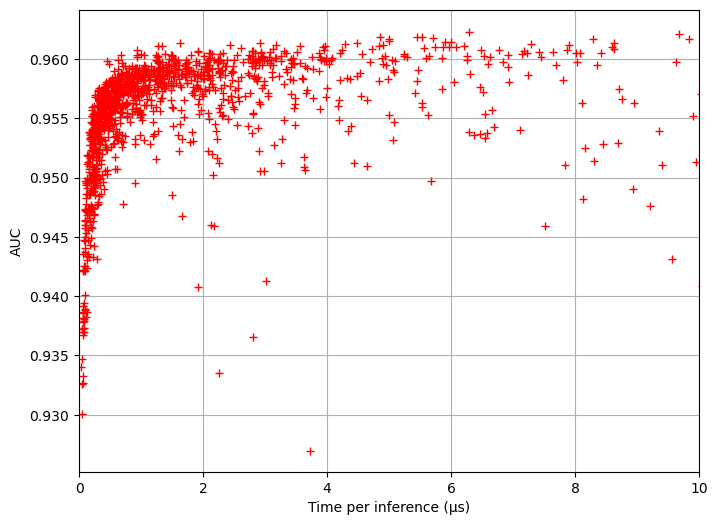

In [8]:
plt.figure(figsize=(8, 6))

plt.subplot(1, 1, 1)
plt.plot(aggregated_report["time_per_predictions_us"]["mean"], aggregated_report["auc"]["mean"], 'r+')
plt.ylabel("AUC")
plt.xlabel("Time per inference (µs)")
plt.xlim((0, 10)) # Update the xlim according to your data.
plt.grid()

plt.show()

Plot an envelope over the quality / speed.

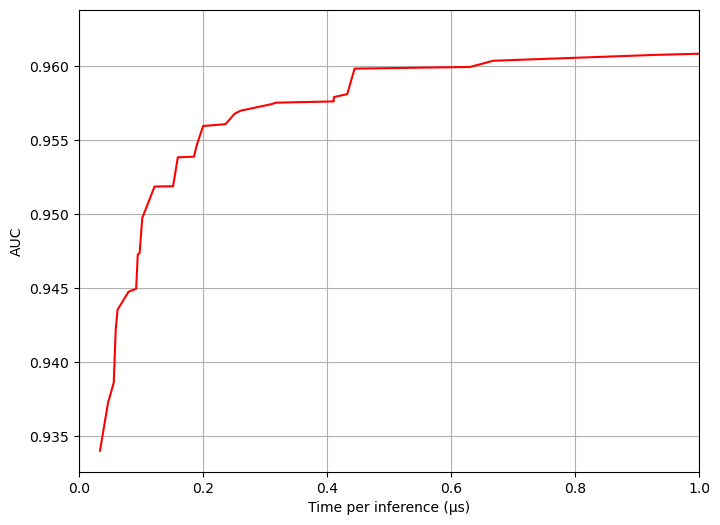

In [9]:
def envelope(sx, sy):
  ps = list(zip(sx, sy))
  ps = [ (x,y) for x,y in ps if not math.isnan(x) and not math.isnan(y)]

  rs = []
  while ps:
    ps.sort(key=lambda v: v[0])
    p = ps.pop(0)
    rs.append(p)
    ps = [v for v in ps if v[1] > p[1]]
  return zip(*rs)

xs, ys = envelope(aggregated_report["time_per_predictions_us"]["mean"], aggregated_report["auc"]["mean"])

plt.figure(figsize=(8, 6))

plt.subplot(1, 1, 1)
plt.plot(xs, ys, "r")
plt.ylabel("AUC")
plt.xlabel("Time per inference (µs)")
plt.xlim((0, 1)) # Update the xlim according to your data.
plt.grid()

plt.show()